In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import datetime

In [2]:
import xgboost as xgb
import sklearn.metrics as skm

In [3]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

In [4]:
def split_data(df, split_date):
    return df[df.index <= split_date].copy(), \
           df[df.index >=  split_date].copy()

In [5]:
#Creates multivariate features
def create_features(df,colName):
    X = df.drop(columns=[colName])
    return X

In [6]:
def z_standardization(df_col):
    for col in df_col.columns:
        col_zscore = col + '_ZS'
        df_col[col_zscore] = (df_col[col] - df_col[col].mean())/df_col[col].std(ddof=0)
    for col in df_col.columns:
        if not col.endswith('_ZS'):
            df_col.drop(col, axis=1,inplace = True)
    return df_col

In [7]:
root = Path('aggregated_data')
joinData_file = 'aggregate_data.csv'   # Original aggregate file
#joinData_file = 'aggregate_data_2.csv'   # NG Consume for PoweGen (All subsector)
#joinData_file = 'aggregate_data_3.csv'   # PowGen from NG (sum EGAT,IPP,SPP)
joinData_df = pd.read_csv(root / joinData_file,index_col=0)
joinData_df.sort_index(inplace=True)

#### Create dataframe

Split and Graph Train & Test data

In [8]:
train, test = split_data(joinData_df, '2008-01-31')

#### Normailized data (Comment out if not require)

In [9]:
#train = z_standardization(train)
#test = z_standardization(test)

In [10]:
train.head(3)

,NG CONS EGAT,NG CONS GSP,NG CONS IPP,NG CONS Industry,NG CONS NGV,NG CONS SPP,NG PRD Domestic,NG PRD Import,POWGEN DEDP,POWGEN EGAT,POWGEN IPP,POWGEN Import,POWGEN SPP,POWGEN VSPP
DS,,,,,,,,,,,,,,
1986-01-31,251.0,75.0,0.0,13.0,0.0,0.0,370.0,0.0,0.0,1841.52,0.0,57.00,0.0,0.0
1986-02-28,235.0,74.0,0.0,12.0,0.0,0.0,350.0,0.0,0.0,1761.38,0.0,52.14,0.0,0.0
1986-03-31,255.0,82.0,0.0,19.0,0.0,0.0,373.0,0.0,0.0,2093.57,0.0,41.86,0.0,0.0


In [11]:
test.head(3)

,NG CONS EGAT,NG CONS GSP,NG CONS IPP,NG CONS Industry,NG CONS NGV,NG CONS SPP,NG PRD Domestic,NG PRD Import,POWGEN DEDP,POWGEN EGAT,POWGEN IPP,POWGEN Import,POWGEN SPP,POWGEN VSPP
DS,,,,,,,,,,,,,,
2008-01-31,905.0,585.0,878.0,365.0,41.0,446.0,2547.0,781.0,1.808,4893.154,5363.751,342.253,1280.140,0.0
2008-02-29,917.0,619.0,967.0,377.0,47.0,452.0,2545.0,927.0,2.148,4725.140,5477.564,170.173,1155.928,0.0
2008-03-31,914.0,594.0,1068.0,370.0,52.0,453.0,2610.0,972.0,3.745,5555.601,6344.419,152.479,1231.518,0.0


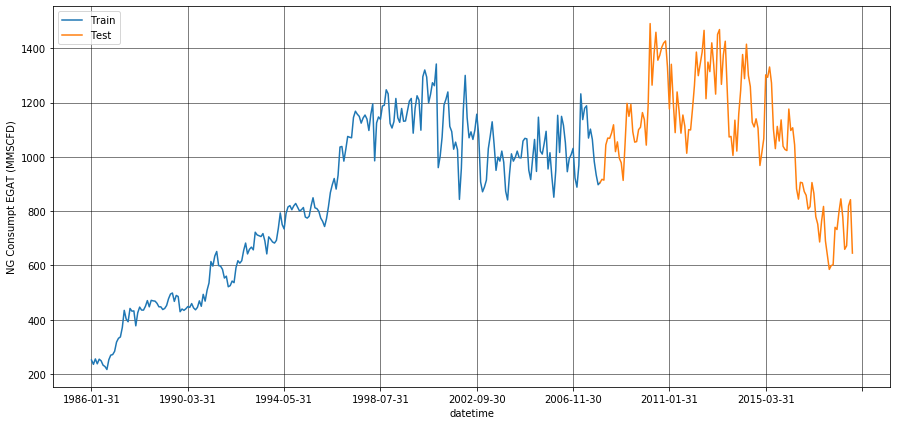

In [12]:
plt.figure(figsize=(15,7))
plt.xlabel('datetime')
#plt.ylabel('NG Consumpt EGAT (Z-Score)')
plt.ylabel('NG Consumpt EGAT (MMSCFD)')
#plt.plot(train.index,train['NG CONS EGAT_ZS'],label='Train')
#plt.plot(test.index,test['NG CONS EGAT_ZS'],label='Test')
plt.plot(train.index,train['NG CONS EGAT'],label='Train')
plt.plot(test.index,test['NG CONS EGAT'],label='Test')
#plt.plot(train.index,train)
#plt.plot(test.index,test)
plt.legend(loc='upper left')
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

In [13]:
#X_train, y_train = create_features(train,'NG CONS EGAT_ZS'), train['NG CONS EGAT_ZS']
#X_test, y_test   = create_features(test,'NG CONS EGAT_ZS'), test['NG CONS EGAT_ZS']

In [14]:
X_train, y_train = create_features(train,'NG CONS EGAT'), train['NG CONS EGAT']
X_test, y_test   = create_features(test,'NG CONS EGAT'), test['NG CONS EGAT']

In [108]:
reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate = 0.2, \
                       booster='gbtree', reg_lambda=3, n_estimators = 1000)
reg.fit(X_train,y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=3, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

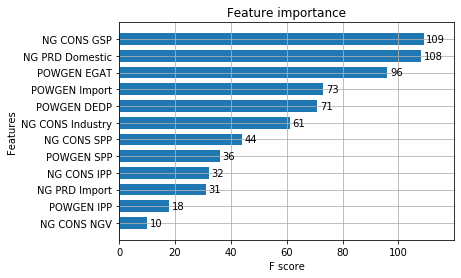

In [109]:
xgb.plot_importance(reg, height=0.7)

In [110]:
X_test_pred = reg.predict(X_test,output_margin=True)

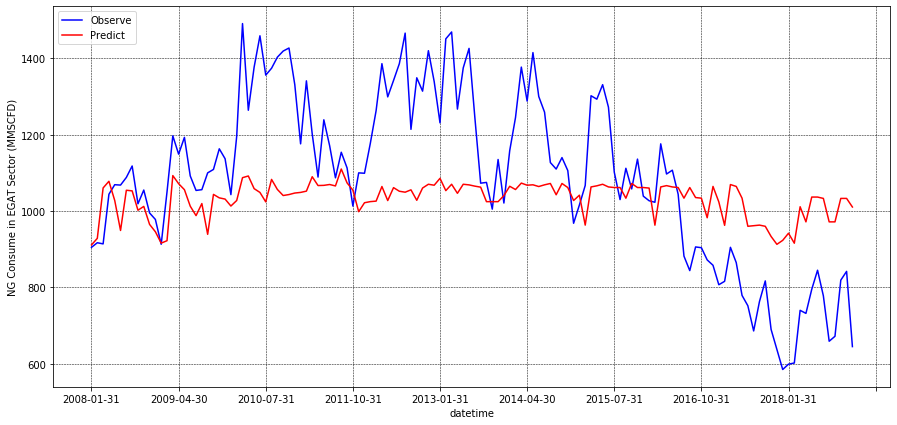

In [111]:
plt.figure(figsize=(15,7))
plt.xlabel('datetime')
plt.ylabel('NG Consume in EGAT Sector (MMSCFD)')
#plt.plot(joinData_df.index, joinData_df['NG Consume by Electricity'], alpha=1, label='Observe',color='b')
plt.plot(y_test.index, y_test, label='Observe',color='b')
plt.plot(X_test.index, X_test_pred, label='Predict',color='r')
plt.legend(loc='upper left')
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.show()

In [40]:
# evaluate predictions
predictions = [round(value) for value in X_test_pred]
yTest = [round(value) for value in y_test]

In [41]:
accuracy = skm.accuracy_score(yTest, predictions, normalize=False)
print("Accuracy: %.2f" % (accuracy * 100.0))

Accuracy: 200.00


In [42]:
prec = skm.precision_score(yTest, predictions,  average='micro')
print("Precision: %.4f" % (prec * 100.0))

Precision: 1.5152


In [43]:
rcScrs = skm.recall_score(yTest, predictions, average='micro')
print("Recal %.4f" % (rcScrs * 100.0))

Recal 1.5152


In [44]:
f1Scrs = skm.f1_score(yTest, predictions, average='micro')
print("F-1 Scores %.4f" % (f1Scrs * 100.0))

F-1 Scores 1.5152


In [45]:
mae = skm.mean_absolute_error(yTest, predictions)
print("mean_absolute_error %.2f" % mae)

mean_absolute_error 158.85


In [46]:
mse = skm.mean_squared_error(yTest, predictions)
print("mean_squared_error %.2f" % mse)

mean_squared_error 38331.58
